# Feedback from previous weeks and other and hints

1. Be careful about your environment remembering variables. Make sure your code works in a new _clean_ environment. In Colab: `Runtime`->`restart Runtime`, in Anaconda's Jupyter: `Kernel`->`Restart`.
2. Keep the file names when saving to GitHub. It's always possible to go back to a previous version, you are not losing anything.
3. Run all the cells before saving to GitHub so the output is saved.
4. Graphs without labels (or units when appropriate) are not worth any point.
5. Do put in sufficient explanatory comments in your code.

For this week you can use these imports at the start of your programs:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Introduction

This week we’ll use some of the techniques from the previous weeks (functions, array slicing, ODEs, ...) to see how to solve numerically for the motion of two bodies which attract each other through a gravitational force. While we can use `odeint()` from last week, we will go into some details of numerical solvers, and see which is applicable when by implementing our own solvers. They could then be compared with the ones available in `odeint()`.

The gravitational force example in this sheet can be extended to several bodies, and since both gravitational and electrostatic forces have a $1/r^2$ distance dependence, the methods used here can be applied also to the case of a number of interacting charged objects.

A numerical study is important since only the very simplest cases have an analytic solution - even just three interacting bodies cannot in general be solved analytically. We first look at the simplest analytically solvable case, that of circular orbits, which you met in PX1121 last year.

## Circular Newtonian orbits - revision

If two bodies are separated by a distance $r$ and interact through gravity, then the force $\mathbf{F_G}$ acting on a body of mass $m$ due to a body of mass $M$ is:

$$
\mathbf{F}_G = - \frac{GMm}{r^2}\hat{\mathbf{r}}
$$

where $\mathbf{\hat{r}}$ is unit vector pointing from the body of mass $M$ to the body of mass $m$.

We shall take the case where the mass $m \ll M$ to simplify the subsequent equations. So we can treat the position of mass M as fixed at the origin. (To solve the more general case analytically, the concept of reduced mass needs to be introduced, which you will meet in another module.)

There are many different possible paths or 'orbits' that the small mass can take, depending on its _initial conditions_. In general it will follow an elliptical orbit of size and eccentricity which can be calculated knowing these initial conditions $\mathbf{r}_0$ and $\mathbf{v}_0$.

In the special case of circular motion, the initial velocity $\mathbf{v}_0$ is perpendicular to $\mathbf{r}_0$ and of the correct magnitude to produce an exactly circular orbit. The centripetal force acting on $m$ is

$$
\mathbf{F}_c = - \frac{mv^2}{r}\hat{\mathbf{r}}
$$

Equating $\mathbf{F}_G = \mathbf{F}_c$ and noting that for circular motion the speed can be related to the angular speed $\omega$ by $v = r\omega$, then we can derive that

$$
\omega^2=\frac{GM}{r^3}
$$

The angular speed is just the rate of change of the angle $\phi$, and since $\omega$ is a constant (for circular motion $r$ does not change!), the angle (or 'phase') as a function of time is $\phi = \omega t$. We can express the motion in two dimensions as (assuming that at $t = 0$ the location is $x=0,y=r$),

$$
\begin{aligned}
x(t) = r \sin(\omega t),\,\, y(t) = r \cos(\omega t)
\end{aligned}
$$

which can be plotted.

## General 2D Newtonian orbits

But orbits are not necessarily circular. We now extend the problem to arbitrary initial conditions. It’s possible to solve this analytically, but we go straight to exploring numerical methods.

The equation of motion of mass $m \ll M$ is

$$
\frac{d^2 \mathbf{r}}{dt^2}=-\frac{GMm}{r^2}\hat{\mathbf{r}}
$$

(Note: breaking this up into components gives two equations

$$
\begin{aligned}
\frac{d^2 x}{dt^2} & = -\frac{GMx}{r^3} \\
\frac{d^2 y}{dt^2} & = -\frac{GMy}{r^3}
\end{aligned}
$$

As we are dealing with only two bodies, and the forces are central, it’s clear that the motion is in a 2D plane, so we don’t need a $z$ component of motion.)

# Our goals

You will solve the last equation using several methods. The goals of the exercises are to

 1. Workout how to solve (i.e. to integrate) the equations of motion above using various methods.


 2. Compare their relative accuracy.


 3. Understand the consequences of different choices of initial conditions – circular orbits and eccentric orbits.


 4. See how to extend to another simple dynamical problem

You will implement three different integration schemes and look at how accurately they solve the orbit equations.

# Basic numerical approach

One way to solve the second order equations of motion is to break it down into two coupled first-order equations. This can be done as follows:

$$
\begin{aligned}
d\mathbf{r}/dt & = \mathbf{v} \\
d\mathbf{v}/dt & = \mathbf{a} = -GM\mathbf{r}/r^3
\end{aligned}
$$

Given some initial positions $\mathbf{r}(t = 0) = [x(0), y(0)]$, and initial velocity components $\mathbf{v}(t = 0) = [v_x(0),v_y(0)]$, then we integrate the first equation to get an update on the position, and the second equation to get an update on the velocity, at the next time step $\Delta t$ later. We then repeat this for subsequent time steps. Let’s see three methods by which this can be done:


## I Euler’s method

The simplest integration method is Euler’s method, which you used in Week 9 of PX1224 last year. The update scheme is (_ensure that you understand this_):

$$
\begin{aligned}
\mathbf{r}(t + \Delta t) & = \mathbf{r}(t) + \mathbf{v}(t)\Delta t \\
\mathbf{v}(t + \Delta t) & = \mathbf{v}(t) + \mathbf{a}(t)\Delta t
\end{aligned}
$$

## II Euler-Cromer method

In the Euler-Cromer method, we update the velocity first, and then use the new velocity to update the position. i.e.,

$$
\begin{aligned}
\mathbf{v}(t + \Delta t) & = \mathbf{v}(t) + \mathbf{a}(t)\Delta t \\
\mathbf{r}(t + \Delta t) & = \mathbf{r}(t) + \mathbf{v}(t + \Delta t)\Delta t
\end{aligned}
$$

An even better method is ...

## III Verlet method

This was popularised by Loup Verlet in 1967 (although first discovered two centuries before) for molecular dynamics simulations. It is very important nowadays for calculating such things as the interaction of large molecules (e.g. for developing theraputic drugs).

The method can be written as

$$
\begin{aligned}
\mathbf{r}(t + \Delta t) & = \mathbf{r}(t) + \mathbf{v}(t)\Delta t + (1/2)\mathbf{a}(t)\Delta t^2 \\
\mathbf{v}(t + \Delta t) & = \mathbf{v}(t) + 1/2 [\mathbf{a}(t)+\mathbf{a}(t + \Delta t)]\Delta t
\end{aligned}
$$

Strictly speaking, this is called the 'velocity Verlet' method. (It is closely related to the so-called 'leapfrog' method.)

So you need to evaluate the acceleration $\mathbf{a}$ at the current point (time $t$) and the next point (time $t+\Delta t$). Since $\mathbf{a}$ depends only on position $\mathbf{r}$ in our case of orbits, this is straightforward because the next position is calculated in the first line.

The clever thing about the integrator is that it is time-reversible, and this means that the energy of the system is in principle exactly (not just approximately) conserved. This leads to huge improvements in accuracy.

# How to program these methods

**Note**: If you are still a little unsure about using functions, _now_ is the time to revise, ask a demonstrator, and go to office hours.

To implement and compare the above methods you should create a general `orbit_solve` function, that will solve your equations for any choice of initial conditions `r0` and `v0`, integration time `tmax` , number of integration points `N` , and (eventually) choice of numerical method.

Since $\mathbf{r}$ and $\mathbf{v}$ are vectors, we write their x- and y-components with the help of a numpy array. The initial conditions `r0` and `v0` will each be length-2 numpy arrays (representing the 2D vectors) that contains the initial position and initial velocity vectors. For example

In [ ]:
# some purely arbitrary values !
r0 = [1, 0] # positive x-component only set to 1
v0 = [0 , 0.3] # negative y-component only set to 0.3

So the `orbit_solve` function would be structured like this (where we use `r[i]` for $\mathbf{r}(t)$, `r[i+1]` for $\mathbf{r}(t + \Delta t)$ and so on):

```python
def orbit_solve (r0, v0, tmax, N, method = 'euler'):
    # set-up the time-step using tmax and N:
    ...
    # set up an array for the output times (using tmax, time-step and N):
    ...
    # set up arrays for the positions and velocities (see below)
    ...
    # include the initial conditions in the arrays
    ...
    # then do the integration for all the integration points
    for i in range (0, N-1):
        r[i+1] = ....
        v[i+1] = ....
    # output the solution (arrays for positions and velocities) versus time
    return t, r, v
```

Include the `method` keyword since you will modify this function shortly. (You will use `if` statements to get the code to use the desired integrator, so that the one `orbit_solve` function can call an Euler, Euler-Cromer or Verlet integrator, depending on the choice input into the `orbit_solve` function.)

The returned values `t`, `r` and `v` should be length-N arrays of the time, position vector, and velocity vector at each time step of the integration (i = 0, 1, 2, ... N-1).

**Help on the vectors**: It’s easy to get confused when dealing with a length-N array (representing N time steps) of length-2 arrays (representing the x- and y-components of vectors).

To define an array r of 2D vectors of length N for example, you can write

In [ ]:
N = 10
r = np.zeros((N,2)) # N rows (time step), 2 columns (x- and y-components)
v = np.zeros((N,2)) # same shape for v

So, with `N` equal to 10, `r` looks like this:

In [ ]:
r

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

Going down the rows is equivalent to stepping in time. The first row of `r` (corresponding to zero time) is `r[0]`,

In [ ]:
r[0]

array([0., 0.])

which we can change:

In [ ]:
x0=10
y0=0
r[0]=[x0,y0]

print(r[0])

[10.  0.]


The first element of this row (corresponding to the x-component) is `r[0][0]`, or alternatively `r[0,0]`,

In [ ]:
r[0,0]

10.0

To get all the rows of column 0, you would use `r[:,0]`

In [ ]:
r[:,0]

array([10.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

which is returned as a 1D array, ready for plotting. Thus, these arrays can then be plotted after the solution has been produced.

# Exercises

This must be marked before you leave the lab. Mark weighting is in brackets. **Save your work to GitHub after having run all cells with `Runtime` -> `Restart and run all`. And do not change the notebook's filename.** Do add comments to your code, you'll lose points if your code is hard to understand. Graphs without labels (or units when appropriate) are not worth any point.

## Exercise 0

See LearningCentral for an example using the [Lotka-Volterra equations](https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations).

## Exercise 1
[6] Complete the orbit_solve function above to implement the Euler method.

In [113]:
import numpy as np
import matplotlib.pyplot as plt


def orbit_solve (r0, v0, tmax, N, G, M, method = 'euler'): # Added G and M as arguments
    dt = tmax / (N - 1)
    t = np.linspace(0, tmax, N) # Time array

    r = np.zeros((N,2)) # Positions array
    v = np.zeros((N,2)) # Velocities array

    r[0] = r0 # Set initial position
    v[0] = v0 # Set initial velocity

    def calculate_acceleration(pos_vec, G_val, M_val):
        distance = np.linalg.norm(pos_vec)
        if distance == 0:
            return np.array([0.0, 0.0])
        return -G_val * M_val * pos_vec / (distance**3)

    #integration
    for i in range (N - 1):
        if method == 'euler':
            # Calculate acceleration at the current position
            current_a = calculate_acceleration(r[i], G, M)

            # Euler's method
            v[i+1] = v[i] + current_a * dt
            r[i+1] = r[i] + v[i] * dt

    return t, r, v


## Exercise 2
[4] Use your function to solve the 2D equations of motion for a circular orbit. For simplicity, you can set $G = 1$ and $M = 1$. Calculate the time period for one orbit and integrate the equations for a few (say two) periods, and 100 points, and plot the (x,y) motion. Does this look like what you expect? How does this change if N is 200 and 400? (Plot all in one figure.)

  **Hint**: To get the right initial conditions for a circular orbit you can do the following. Choose some separation, and some initial position (for example, $r = 10$ and $x(0) = 10$ and $y(0) = 0$). Then calculate the theoretical value of $\omega$ for a circular orbit, and hence the appropriate initial values of $v_x(0)$ and $v_y(0)$. Note that the velocity vector will be perpendicular to the position vector for a circular orbit. You can work out what the time period $T$ is for one orbit, and choose a time step a multiple of $\Delta t = T/100$ etc.


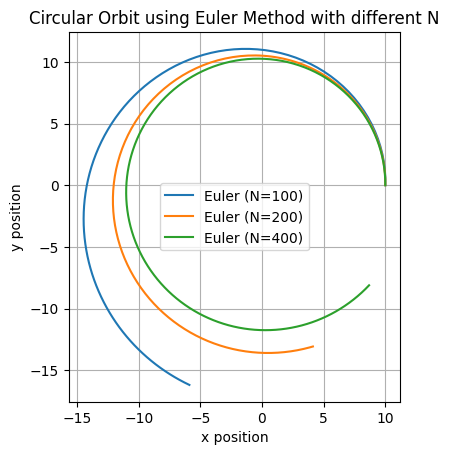

In [120]:
import numpy as np
import matplotlib.pyplot as plt


#Calculate omega
G=1
M=1

#Initial position
r0=np.array([10.,0.])

#Initial velocity
v_magnitude = np.sqrt(G * M / np.linalg.norm(r0))
v0=np.array([0., v_magnitude]) # Set to achieve a circular orbit

#Calculate period for a circular orbit (T = 2*pi*r / v)
T = 2 * np.pi * np.linalg.norm(r0) / v_magnitude

# Initialize plot
plt.figure()

# N = 100
N_points_100 = 100
t_sol_100, r_sol_100, v_sol_100 = orbit_solve(r0, v0, T, N_points_100, G, M)
plt.plot(r_sol_100[:,0], r_sol_100[:,1], label=f'Euler (N={N_points_100})')

# N = 200
N_points_200 = 200
t_sol_200, r_sol_200, v_sol_200 = orbit_solve(r0, v0, T, N_points_200, G, M)
plt.plot(r_sol_200[:,0], r_sol_200[:,1], label=f'Euler (N={N_points_200})')

# N = 400
N_points_400 = 400
t_sol_400, r_sol_400, v_sol_400 = orbit_solve(r0, v0, T, N_points_400, G, M)
plt.plot(r_sol_400[:,0], r_sol_400[:,1], label=f'Euler (N={N_points_400})')

plt.xlabel('x position')
plt.ylabel('y position')
plt.title('Circular Orbit using Euler Method with different N')
plt.grid(True)
plt.gca().set_aspect('equal')
plt.legend()




## Exercise 3

[6] Modify your function to include both the Euler-Cromer method and the Verlet method. The method keyword in the function should be used to select the integration method used in the function (using an `if` statement).

In [117]:
import numpy as np
import matplotlib.pyplot as plt


def orbit_solve (r0, v0, tmax, N, G, M, method = 'euler'):
    dt = tmax / (N - 1)
    t = np.linspace(0, tmax, N) # Time array

    r = np.zeros((N,2)) # Positions array
    v = np.zeros((N,2)) # Velocities array

    r[0] = r0 # Set initial position
    v[0] = v0 # Set initial velocity

    def calculate_acceleration(pos_vec, G_val, M_val):
        distance = np.linalg.norm(pos_vec)
        if distance == 0:
            return np.array([0.0, 0.0])
        return -G_val * M_val * pos_vec / (distance**3)

    #integration
    for i in range (N - 1):
        if method == 'euler':
            # Calculate acceleration at the current position
            current_a = calculate_acceleration(r[i], G, M)

            # Euler's method
            v[i+1] = v[i] + current_a * dt
            r[i+1] = r[i] + v[i] * dt

        elif method == 'euler_cromer':
            # Calculate acceleration at the current position
            current_a = calculate_acceleration(r[i], G, M)

            # Euler-Cromer method
            v[i+1] = v[i] + current_a * dt
            r[i+1] = r[i] + v[i+1] * dt # Use new velocity for position update

        elif method == 'verlet':
            # Verlet method
            current_a = calculate_acceleration(r[i], G, M)
            r[i+1] = r[i] + v[i] * dt + 0.5 * current_a * dt**2
            next_a = calculate_acceleration(r[i+1], G, M)
            v[i+1] = v[i] + 0.5 * (current_a + next_a) * dt

        else:
            raise ValueError(f"Unknown method: {method}")

    return t, r, v

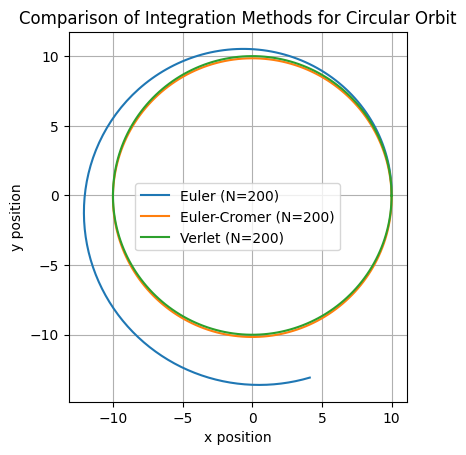

In [119]:
N_points_compare = 200

plt.figure()

# Euler Method
t_euler, r_euler, v_euler = orbit_solve(r0, v0, T, N_points_compare, G, M, method='euler')
plt.plot(r_euler[:,0], r_euler[:,1], label=f'Euler (N={N_points_compare})')

# Euler-Cromer Method
t_ec, r_ec, v_ec = orbit_solve(r0, v0, T, N_points_compare, G, M, method='euler_cromer')
plt.plot(r_ec[:,0], r_ec[:,1], label=f'Euler-Cromer (N={N_points_compare})')

# Verlet Method
t_verlet, r_verlet, v_verlet = orbit_solve(r0, v0, T, N_points_compare, G, M, method='verlet')
plt.plot(r_verlet[:,0], r_verlet[:,1], label=f'Verlet (N={N_points_compare})')

plt.xlabel('x position')
plt.ylabel('y position')
plt.title('Comparison of Integration Methods for Circular Orbit')
plt.grid(True)
plt.gca().set_aspect('equal')
plt.legend()
plt.show()


## Exercise 4

[4] Compare the Euler, Euler-Cromer and Verlet method by plotting a graph for a given number of points. Again, choose just a few orbits.


## Exercise 5

Not marked, but useful to check your results: modify your function to also include the [odeint](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html) function (which uses Adams methods (predictor-corrector) in the nonstiff case, and Backward Differentiation Formula (BDF) methods (the Gear methods) in the stiff case). Compare your results. You can also add the newer [solve_ivp](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html) function from scipy, which itself includes many integration methods.

## Exercise 6

Not marked. If you have time, explore some elliptical orbits.

## Exercise 7

Not marked. If you still have time, it’s useful to plot out the total energy of the mass $m$ versus time. Do this for 10 orbits this time, and 200 points.

 **Hint**: The total energy is just $E = T + V = mv^2/2+V(r) = mv^2/2 - G M m/r$ . So it’s easy to find the energy against time (as an array) given the position and velocity arrays. (Pick a mass $m = 1$ since it only scales the energy and doesn’t change the equations of motion as we have fixed $M$ anyway.)